In [1]:
import os
import torch

from skimage import io, transform
from torch import nn
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter

from batch_generator import BatchGenerator

In [2]:
batch_size = 16

In [3]:
train_batch_generator = BatchGenerator('/main/ssd/data/ocr/gen_100000_rc_let_num_sw10/')
recognizable_characters = train_batch_generator.recognizable_characters

train_data_loader = DataLoader(train_batch_generator, batch_size=batch_size, shuffle=True)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


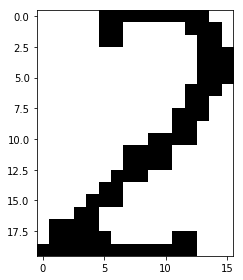

In [4]:
input, label = train_batch_generator[2]
img = input[:-1].reshape(train_batch_generator.output_shape)
io.imshow(img)
print(label)

In [5]:
network = nn.Sequential(
    nn.Linear(321, 100),
    nn.Sigmoid(),
    nn.Linear(100, len(recognizable_characters))
    ).cuda()

optimizer = torch.optim.Adam(network.parameters())
loss_fn = nn.BCEWithLogitsLoss()

In [7]:
report_path = '/main/ssd/logs/ocr/2linear_2'
writer = SummaryWriter(report_path)
logs_freq = 100

In [ ]:
n_epoch = 10
iteration = 0
for epoch in range(n_epoch):
    for inputs, targets in train_data_loader:
        iteration += 1
        inputs = inputs.float().cuda()
        targets = targets.float().cuda()
        predictions = network(inputs)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if iteration % logs_freq == 0:
            writer.add_scalar("train loss", loss, iteration)
            accuracy = (targets.argmax(1) == predictions.argmax(1)).float().mean()
            writer.add_scalar("train accuracy", accuracy, iteration)
    network.cpu()
    state_dict = network.state_dict()
    torch.save(state_dict, os.path.join(report_path, f'state_dict_{epoch+1}'))
    network.cuda()


In [9]:
activated_model = nn.Sequential(
    network,
    nn.Sigmoid()
)

In [10]:
dummy_input = torch.zeros(1, 321).float().cuda()
torch.onnx.export(activated_model, dummy_input, "activated_model_2.onnx")